In [2]:
%%javascript
$('#menubar').toggle();

<IPython.core.display.Javascript object>

Helper functions for this lecture:

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from rl import *
from mdp import sequential_decision_environment
from mdp import value_iteration
import time
from utils import argmax, vector_add, print_table
import sys
print(sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [8]:
def graph_utility_estimates_q(agent_program, mdp, no_of_iterations, states_to_graph):
    graphs = {state:[] for state in states_to_graph}
    
    for iteration in range(1,no_of_iterations+1):
        run_single_trial(agent_program, mdp)
        
        U = defaultdict(lambda: -1000.)
        for state_action, value in agent_program.Q.items():
            state, action = state_action
            if U[state] < value:
                U[state] = value            

        for state in states_to_graph:            
            graphs[state].append((iteration, U[state]))
    
    for state, value in graphs.items():
        state_x, state_y = zip(*value)
        plt.plot(state_x, state_y, label=str(state))
    
    plt.ylim([-2.6,2.6])
    plt.legend(loc='lower right')
    plt.xlabel('Iterations')
    plt.ylabel('U')

In [9]:
def value_iteration(mdp, epsilon=0.0001):
    "Solving an MDP by value iteration. [Figure 17.4]"
    U1 = {s: 0 for s in mdp.states}
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
            delta = max(delta, abs(U1[s] - U[s]))
        if delta < epsilon * (1 - gamma) / gamma:
            return U

In [10]:
def expected_utility(a, s, U, mdp):
    "The expected utility of doing a in state s, according to the MDP and U."
    return sum([p * U[s1] for (p, s1) in mdp.T(s, a)])

def best_policy(mdp, U):
    """Given an MDP and a utility function U, determine the best policy,
    as a mapping from state to action. (Equation 17.4)"""
    pi = {}
    for s in mdp.states:
        pi[s] = argmax(mdp.actions(s), key=lambda a: expected_utility(a, s, U, mdp))
    return pi

---

# Artificial Intelligence - COMPSCI4004 2018-2019

<h2> Week 7: Learning from rewards and observations</h2><small><small><small>v2019a</small></small></small>

Bjørn Sand Jensen, bjorn.jensen@glasgow.ac.uk, School of Computing Science, University of Glasgow, SAWB 306
<br>


----

### Reading &  learning objectives

<div class="alert alert-danger">
<font color=black>
<b>Reading: </b><br><br>
- AIMA Chapter (17.1-17.4) + 21 (21-21.3)<br>
</font>
</div>

<div class="alert alert-info">
<font color=black>
<b>Learning objectives:</b><br><br>
- Understand and explain the goal and standard formulations of reinforcement learning<br>
- Understand and explain active ADP and active Q-learning. <br>
- Be able to apply reinforcement learning to basic problems [the lab and AE]<br>
</font>
</div>

<div class="alert alert-warning">
<font color=black>
<b>Key concepts:</b>Reinforcement learning, Passive vs active, model-based vs model-free, direct sampling, (active/passive) ADP, Q-learning<br>
</font>
</div>

----

### Probability, Utility and Decision (review)

* <font color=blue>Probability</font>
    $$P(H|e)=\frac{P(e|H)P(H)}{P(e)}=\frac{P(e|H)P(H)}{\sum_h P(e|H=h)P(H=h)}=\frac{P(e,H)}{\sum_h P(e,H=h)}$$



* <font color=blue>Utility</font>
    $$A \succ B <=> U(A) > U(B)$$
    $$U: X-> \mathbb{R}$$
    
    
* <font color=blue>Decision Theory</font>
    * Choose the action that maximizes expected utility

\begin{align}
EU\left( {a|{\mathbf{e}}} \right) &= \sum\limits_{s'}^{} {P\left( {\,\operatorname{Result} (a) = s'\,\,|\,\,a,{\mathbf{e}}} \right)U(s')} \\ 
&= {E_{P\left( {{\mkern 1mu} s'{\mkern 1mu} {\mkern 1mu} |{\mkern 1mu} {\mkern 1mu} a,{\mathbf{e}}} \right)}}\left\{ {U(s')} \right\} \\
&= {\mathbb{E}_{s'\sim P\left( {{\mkern 1mu} s'{\mkern 1mu} {\mkern 1mu} |{\mkern 1mu} {\mkern 1mu} a,{\mathbf{e}}} \right)}}\left\{ {U(s')} \right\} 
\end{align}
* Choose the optimal action by maximizing over EU:
$$a' = \mathop {\arg \max }\limits_a EU\left( {a|{\mathbf{e}}} \right)$$

* Choose the optimal action by maximizing over EU with respect to a:
$$a' = \mathop {\arg \max }\limits_a EU\left( {a|{\mathbf{e}}} \right)$$

* <font color=blue>Sequential decision making under uncertainty</font>
    * Markov decision process provides a framework
    * Choose the policy (i.e. actions) that maximizes the expected sum of discounted rewards (expected utility)
    
    <br>
        
    * 1) Bellman equations (optimality):
$$U^*(s)=R(s)+\gamma\, max_a \sum_{s'} p(s'|s,a)U^*(s')$$
            
    * 2) Solve Bellman equations (i.e. find $U(s)$ for all states) using your favorite numerical solver (here: Value iteration, Policy Iteration)
    * 3) Find policy by maximum expected utility principle
$$EU\left( {a=\pi(s)|{\mathbf{s}}} \right) = \sum\limits_{s'}^{} {P\left( {\,\operatorname{Result} (a) = s'\,\,|\,\,a,{\mathbf{s}}} \right)U(s')}    $$


----

### Learning from rewards and observations

__Recall__: We have so far assumed that we know $P(s'|s,a)$ and $R(s)$ <br>


__Idea__: Let's try to <font color=blue>___learn___</font> the necessary quantities by exploring the environment (i.e. go gather information) and observe rewards.

__Machine learning - overview__
- Supervised Learning
    - $\{(\mathbf{x}_n,\mathbf{y}_n)\}^{n=1:N}$: classification, categorization, regression, ranking, ....
    - E.g. classifying the person in an image, cat or dog, speech recognition, and many other examples.
    - A correct answer for each instance (in the traning set) i.e. episodic problem.
    
    
- Unsupervised learning
    - $\{(\mathbf{x}_n)\}^{n=1:N}$: grouping/clustering, dimensionality reduction, ...
    - E.g. clustering faces (without) knowing their identify
    
    
- Reinforcement Learning: 
    - Learning from occasional rewards
    - Cost function is the long term (expected) reward

<br>

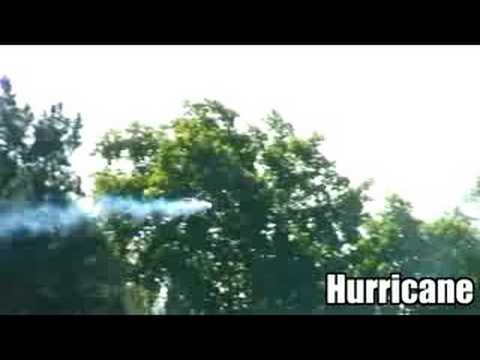

In [4]:
from IPython.display import YouTubeVideo
YouTubeVideo('VCdxqn0fcnE')

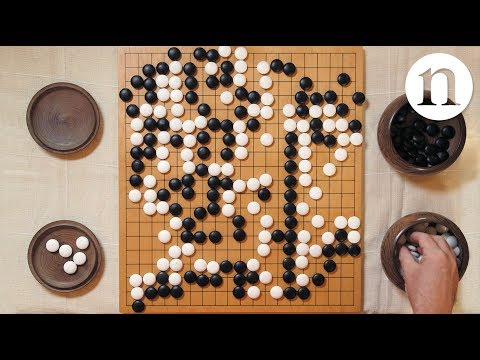

In [3]:
from IPython.display import YouTubeVideo
YouTubeVideo('g-dKXOlsf98')

----

### Reinforcement Learning

__Idea__: Let's try to <font color=blue>___learn___</font> the nessesary quantities by exploring the enviroment (i.e. go gather information).

<br>

<font color=green>Example:</font> 

<img src="./resources/maze_0b.png" style="width:500px">
<img src="./resources/exampleenv.png" style="width:600px">

- A __given__ policy leads to the following dataset/observations when executed three times (episodes):
<img src="./resources/exampledata.png" style="width:60%">

<font color=blue>__Goal__:</font> Use the observed rewards (over multiple trials/episodes) to lean the utilities.

$${U^\pi }(s) = {E_{P({S_t}| \cdot , \pi)}}\left\{ {\sum\limits_{t = 0}^\infty  {{\gamma ^t}R\left( {{S_t}} \right)} } \right\}$$

----

### Assumptions and overview

- <font color=blue>Passive vs active</font>
    - Passive: Fixed and know policy; we need to estimate $P(s'|s,a)$ and $R(s)$
    - Active: Unknown policy; we need to estimate $P(s'|s,a)$ and $R(s)$ while determining the policy/actions.


- <font color=blue>Model-based vs model-free</font>
    - __Model-based__: Explicitly represent and learn $P(s'|s,a)$, $R(s)$
    - __Model-free__: No explicit representation of $P(s'|s,a)$ (e.g. Q-learning)


- <font color=blue>Tabular vs function approximations</font>
    - __Tabular__: Represent probabilities in tables
    - __Function approximation__: Represent knowledge about utilities and actions as a function mapping directly from states to utility.
        - => Generalization, can predict policy for states despite not having visited them yet !

----

### Passive Reinforcement

__Setup__: Given a policy; learn the transition model and rewards, in order to evaluate the utility of the policy.

##### Naiive approach: Direct Utility Estimation (naiive sampling)

<font color=blue>__Idea__</font>: The utility of a state is the expected total reward from that state onward (called the expected reward-to-go), and each trial provides a sample of this quantity for each state visited. Let's just compute the utility as the ___running average___ of the observed rewards from that state onwards to the terminal state.

<font color=green>Example:</font>
$${U^\pi }(s) = {E_{P({S_t}| \cdot , \pi)}}\left\{ {\sum\limits_{t = 0}^\infty  {{\gamma ^t}R\left( {{S_t}} \right)} } \right\}$$

<img src="./resources/exampledata.png" style="width:600px">

First trail/episode - total reward-to-go (not discounted):

- (1,1): 7 x -0.04 + 1 = 0.72<br>
=> U(1,1) = (0.72 + 0.84)/2 <br>

<br>

- (1,2): 6 x -0.04 + 1 = 0.76
- (1,2): 4 x -0.04 + 1 = 0.84<br>
=> U(1,2) = (0.76 + 0.84)/2 = 0.8 <br>

<br>

- (1,3): 5 x -0.04 + 1 = 0.80
- (1,3): 3 x -0.04 + 1 = 0.88 <br>
=> U(1,3) = ?


<font color=blue>__Properties__</font>:
- Will converge to the true value of the utility, $U(s)$, if we visit all states a number of times.   
- It is essentially a supervised machine learning problem (mapping from state to reward-to-go)!

<font color=blue>__Issue__</font>:
- We need observed many episode to update to estimate the mean utility for each state
- Ignores the connection between neighboring states
    - E.g. the Bellman equation suggests that (3,2) is also likely to have a high utility, because it leads to (3,3), but direct utility estimation learns nothing until the end of the trial
    - => slow convergence of the utility estimates

... but is actually often used as part of other RL schemes (e.g. AlphaGo)!

----

##### Adaptive Dynamic Programming

<font color=blue>__Idea__</font>:: Take advantage of the constraints between states by learning the transition model, $P(s'|s,a)$ that connects them and solve the corresponding Markov decision process to determine the utilities
1. Estimate: $$P(s' | s, a) \leftarrow N_{s'|sa}[s' , s, a] / N_{sa}[s,a]$$ ("learning")
2. Solve the fixed-policy Bellman equations  (POLICY-EVALUATION):
    $${U_i}(s) = R(s) + \gamma \sum\limits_{s'}^{} {P\left( {s'|{\pi _i}(s),s} \right){U_i}(s')} $$
3. Return the action from the fixed-policy

... iterate

<img src="./resources/passiveadp.png" style="width:600px">

----

##### Temporal Difference Learning

<font color=blue>__Idea__</font>:: Use the observed immediate ___transitions___ to adjust the utilities of the observed states so that they agree with the Bellman
equations.

- E.g. consider the transition from (1,3) to (2,3). As a result of the first trial, the utility estimates are $U^\pi(1, 3)=0.84$ and $U^\pi(2, 3)=0.92$. Now, if this transition occurred all the time, we would expect the utilities to obey the equation:

$$U^\pi(1, 3) = −0.04 + U^\pi(2, 3) ,$$

so $U^\pi(1, 3)$ would be 0.88 and its current estimate is too low and should be increased a bit.

__TD learning procedure__:
1. Select action from policy in state $s$, observe transition from $s$ to $s'$ (i.e. only one local observation)
2. Estimate/guess before: ${U^\pi }(s)$
3. Estimate/guess after observing the _one_ step : $${R\left( s \right) + \gamma {U^\pi }(s')}$$ (TD target)
4. Updated assuming the observed transition happends all the time:

$${U^\pi }(s) = {U^\pi }(s) + \alpha \left( {R\left( s \right) + \gamma {U^\pi }(s') - {U^\pi }(s)} \right)$$

- But we know the step doesn't happend all the time (unless in deterministic environment) so use a small step-size $\alpha$.

... itereate (update s to s')

<br>    

<img src="./resources/passivetdagent.png" style="width:600px">

__Properties__:
- Very simple update rules
- No transition model (i.e. model free) !
- Consistency: TD converges to the true policy (with proper $\alpha$).

__Issues__:
- Takes a lot of iterations (e.g. only updates one utility at the time; not all the neighbors)

----

### Active reinforcement learning ("control")

__Issue with passive RL__: For real-world scenarios we do not know the policy and need to take into account the fact that the agent has a choice of actions.

Bellman:

$$U(s) = R(s) + \gamma \mathop {\max }\limits_{a \in A(s)} \sum\limits_{s'}^{} {P\left( {s'|a,s} \right)U(s')} $$

<font color=darkmagenta>$$\pi^*(s) = \mathop {\arg \max }\limits_{a \in A(s)} \sum\limits_{s'}^{} {P\left( {{\mkern 1mu} s'{\mkern 1mu} {\mkern 1mu} |{\mkern 1mu} {\mkern 1mu} a,s} \right)U(s')}$$</font>

----

__Active ADP Greedy__:

Input: Initial values for $P(s'|s,a)$ and $R(s)$
1. Update $P(s'|s,a)$ and $R(s)$, i.e. $$P(s' | s, a) \leftarrow N_{s'|sa}[s' , s, a] / N_{sa}[s,a]$$
2. Solve Bellman (non-fixed policy solution), i.e. get current estimate of U(s) with the updated model
3. Select one-step action to maximize the expected utility given U
4. Take action and observe resulting state and reward (and save)

<br>

... iterate

----



___Issue___: The greedy agent very seldom converges to the optimal policy (i.e. takes the lower route)

<img src="./resources/greedysubopt.png" style="width:600px">

Why is that ?

<br>

- The learned model is not the same as the true environment; what is optimal in the
learned model can therefore be suboptimal in the true environment. 
- __The greedy active ADP has overlooked that the action does more than just result in rewards - it also contrbutes to learning the model !__

---
___Solution___: Exploration vs exploitation trade-off 
- Explore the environment to get larger reward in the long run - but to not "over" explore (vasting resources/time)
    - E.g. With probability 1/t choose a random action
- Optimal exploration is generally very difficult to analyse
- E.g. With probability 1/t choose a random action

<br>
<br>

__One suggestion__:

$${U^ + }(s) = R(s) + \gamma \mathop {\max }\limits_{a \in A(s)} f\left( {\sum\limits_{s'}^{} {P\left( {s'|a,s} \right){U^ + }(s')} ,{N_{sa}}} \right)$$
where
- $f(u,n)$ is a exploration function trading off optimistic utility (under the model) vs exploration (learning a better model).
- $U^+$ optimistic estimate of the utility (i.e., the expected reward-to-go) of the state s (we think that there are rewards uniformaly scattered around, initially at least)
- $N(s, a)$ be the number of times action a has been tried in state s.

$$f\left( {u,n} \right) = \left\{ {\begin{array}{*{20}{c}}
  {{R^ + }\,\,\,if\,n < {N_e}} \\ 
  {u\,\,\,otherwise} 
\end{array}} \right.$$

where
- $R^+$ is an optimistic estimate of the best possible reward obtainable in any state and 
- $N_e$ is a fixed parameter (minimum number of times a state-action should be attempted)
----

##### Active ADP (exploratory)

Effectively the same a Active ADP Greedy but with the "exploration" Bellman equations
<br>

<img src="./resources/adpexp.png" style="width:800px">
<center>$R^+ = 2$ and $Ne = 5$</center>

----

##### Q-learning (model-free)

__Idea__: Learn an action-utility representation instead of learning utilities, i.e. aim directly at mapping states to actions without the model.

$$U(s) = \mathop {\max }\limits_a Q(s,a)$$

Bellman equations for the Q-function:

$$Q(s,a) = R(s) + \gamma \sum\limits_{s'}^{} {P\left( {s'|a,s} \right)\mathop {\max }\limits_{a'} Q(s',a')} $$

Exploit TD learning: Use the observed ___transitions___ to adjust the utilities of the observed states so that they agree with the Bellman
equations.


$$Q(s,a) = Q(s,a) + \alpha (R\left( s \right) + \gamma \mathop {\max }\limits_{a'} Q(s',a') - Q(s,a))$$
- Updated whenever action $a$ is executed in state $s$ leading to state $s'$ (i.e. we now have evidence that this transition can occur) .



Adding exploration gives you the very popular Q-learning algorithm.


<img src="./resources/qlearner.png" style="width:800px">

----

<b><font color=green>Example (revisited):</font></b>

<img src="./resources/maze_0.png" style="width:700px">


#### Value Iteration (ground-truth)

In [37]:
U_opt = value_iteration(sequential_decision_environment) # rerun solver
U_opt

{(0, 1): 0.39850680143125394,
 (1, 2): 0.6495863318636782,
 (3, 2): 1.0,
 (0, 0): 0.29645419831913844,
 (3, 0): 0.12993648280124198,
 (3, 1): -1.0,
 (2, 1): 0.4864404379765214,
 (2, 0): 0.3447854954711281,
 (2, 2): 0.7953622365504776,
 (1, 0): 0.2539524935568401,
 (0, 2): 0.5094142322350038}

In [38]:
pi_opt = best_policy(sequential_decision_environment, U_opt)
pi_opt

{(0, 1): (0, 1),
 (1, 2): (1, 0),
 (3, 2): None,
 (0, 0): (0, 1),
 (3, 0): (-1, 0),
 (3, 1): None,
 (2, 1): (0, 1),
 (2, 0): (0, 1),
 (2, 2): (1, 0),
 (1, 0): (1, 0),
 (0, 2): (1, 0)}

In [39]:
print_table(sequential_decision_environment.to_arrows(pi_opt))

>   >      >   .
^   None   ^   .
^   >      ^   <


#### Q-learning

Q-table with north = (0, 1),south = (0,-1),west = (-1, 0),east = (1, 0)

In [40]:
%psource QLearningAgent

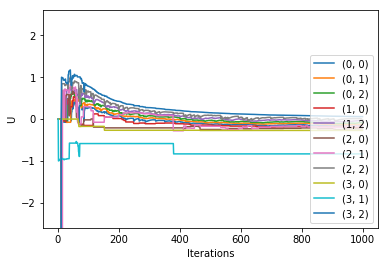

In [60]:
no_of_iters = 1000
q_agent = QLearningAgent(sequential_decision_environment, Ne=5, Rplus=10, 
                         alpha=lambda n: 60./(59+n))
graph_utility_estimates_q(q_agent, sequential_decision_environment, no_of_iters, [(0,0),(0,1),(0,2),(1,0),(1,2),(2,0),(2,1),(2,2),(3,0),(3,1),(3,2)])  

In [57]:
q_agent.Q

defaultdict(float,
            {((0, 0), (1, 0)): 0.16755550383027662,
             ((0, 0), (0, 1)): -0.10478572174094562,
             ((0, 0), (-1, 0)): -0.1307867132867133,
             ((0, 0), (0, -1)): -0.10590764087842354,
             ((1, 0), (1, 0)): 0.19652764600142533,
             ((1, 0), (0, 1)): -0.10293706293706295,
             ((1, 0), (-1, 0)): -0.0758963133640553,
             ((1, 0), (0, -1)): -0.0759999433406361,
             ((2, 0), (1, 0)): -0.0962191780821918,
             ((2, 0), (0, 1)): 0.18065780026813896,
             ((2, 0), (-1, 0)): -0.07611976440083822,
             ((2, 0), (0, -1)): -0.0759999433406361,
             ((2, 1), (1, 0)): -0.0939133441726363,
             ((2, 1), (0, 1)): -0.7703964331846485,
             ((2, 1), (-1, 0)): 0.4311473699375678,
             ((2, 1), (0, -1)): -0.6361283711358927,
             ((3, 1), None): -0.8517314267276732,
             ((3, 0), (1, 0)): -0.10293706293706295,
             ((3, 0), (0, 1)): -0.9

In [43]:
U = defaultdict(lambda: -1000.) 
for state_action, value in q_agent.Q.items():
    state, action = state_action
    if U[state] < value:
        U[state] = value         
U

defaultdict(<function __main__.<lambda>()>,
            {(0, 0): -0.20968643498638898,
             (1, 0): -0.23035039404707805,
             (2, 0): -0.24736233268912994,
             (3, 0): -0.2678370452924277,
             (3, 1): -0.9309404060179411,
             (0, 1): -0.1748254788039172,
             (0, 2): -0.14137362777328577,
             (1, 2): -0.09151292462950826,
             (2, 2): -0.04765845021212309,
             (3, 2): 0.008784080717034383,
             (2, 1): -0.2805036564083392})

In [44]:
pi_opt = best_policy(sequential_decision_environment, U)

In [45]:
print_table(sequential_decision_environment.to_arrows(pi_opt))

>   >      >   .
^   None   ^   .
^   <      <   v



-----
### RL Evaluation

___Issue___: A large choice of different models with many algorithmic choices to be made (even for a simple problem)...

For example:
- Which method / model ?
- Parameters changes the results, which setting is better ?
- Initialisation changes the result (e.g. randomness in the environment), which is better ?
- Number of iterations changes the results, converged ?
- ...

For standard search based methods, theoretical computing science has been able to prove complexity, optimality for many (e.g. A-star) under well-defined conditions.

In dealing with __real-world AI problems__ we are often often left with asymptotic bounds depending on some property of the problem. This effectively means that we often need to do a large amount of empirical evaluation (we can still do theoretical stuff asymptotically):



#### Aspects
- __Completeness__
    - Will the procedure find a solution if there is one ?    

- __Optimality__
    - Does it find the optimal solution, i.e. policy ?
    
- __Complexity__
    - Space: How much memory does the procedure require ?
    - Time: How quickly does it solve it?
        - I) Learning
        - II) Policy estimation / execution
        
- __Robustness__
    - Is the method/parameter choice robust?
        - Robust for the same problem (e.g. repeat the experiment)
        - Does it generalize to new problem of the same type
            - e.g. can we apply the same procedure for learning and policy estimation to variations of teh same problem (e.g. different start and goal states)?
        - Does it generalize to new problem of the same type
            - e.g. can we apply the same procedure for learning and policy estimation to variations ?
    

#### Evaluation setting
<br>
<center>Human-learning <-> Toy problems (4x3 world) </center>

<br>

<center>Real-world $<->$ Simulator</center>


- Real-world
    - Human: Highly complex goal ("happy life"), albeit often divided subgoals, i.e. some repeated tasks       


- Simulation-based
    - Option to learn/memorize across episodes/trials
        - e.g. replay a video game

#### Aspects to consider when evaluating reinforcement agents

- Problem formulation/modelling: 
    - e.g. is MDP suitable
    - e.g. is the discount factor appropriate?
    - e.g. are the exploration parameters appropriate?         
- Validate simulations settings 
     - e.g. number of iterations leading to convergence        
- Evaluate performance across relevant random aspects (e.g. random initialisations, random effects in the environment)    
    - e.g. consider average performance and variance across repetitions
- Generalization across problem variations...
    - e.g. have your agent learned to solve all mazes in the world
- Generalization across problem types/domains/tasks...    
    - e.g. have you agent learned to solve fundamentally different tasks

- Generalization: idealy, we'd need to select our model, algorithm and parameters on a held-out problemtask/variant in order to estimate the agents ability to generalize

And we should always evaluate based on a set of well-defined metrics / performance measures...

----
### Performance Metrics

__Observed reward__:
- per episode/trial (e.g mean and variance)
- per action (e.g mean and variance)
- ...

__Utility loss__ ( Q(s,a) loss):

${\mathbf{U}}$ is a vector of the utilities ${\mathbf{U}} = {[U(s0),U(s1),...U({sn})]^ \top }$

$$\begin{gathered}
  E = \left\| {{\mathbf{\hat U}} - {\mathbf{U}}} \right\|_{2}^2 = \sum\limits_{\forall s}^{} {{{\left( {\hat U\left( s \right) - U\left( s \right)} \right)}^2}}  \hfill \\
    {E_{RootMeanSqure}} = \sqrt {\frac{1}{{{N_S}}}\sum\limits_{\forall s}^{} {{{\left( {\hat U\left( s \right) - U\left( s \right)} \right)}^2}} }  \hfill \\ 
  {E_\infty } = \left\| {{\mathbf{\hat U}} - {\mathbf{U}}} \right\|_\infty ^{} = {\max _s}\left( {{\mathbf{\hat U}} - {\mathbf{U}}} \right) \hfill \\
\end{gathered}$$



__Policy loss__: 
The most the agent can loose by executing a suboptimal policy compared to the optimal one

$$\left\| {{U^{\pi_i}} - U} \right\|_\infty < \epsilon\,\,\,\,then\,\,\left\| {{U^{{\pi _i}}} - U} \right\|_\infty < 2\,\epsilon\gamma /(1 - \gamma )$$

... but what is $\epsilon$ ??
 
    
__Goal loss__:

- Number of times an agent reaches the goal ....

---

### Summary

* The real-world is uncertain but we still need to make decisions and take actions based on uncertain environments.
    - MDPs provide a useful model for many real-world problems  
    
    
* We typically __do not__ know the rewards and transition models so we need to learn them as part of the decision making process, for example using reinforcement learning techniques


* Passive RL techniques (fixed policy)
    - Passive ADP
    - 

* Active reinforcement learning techniques, in particular    
    * ADP model-based on the Bellman equations and greedly finds a policy 
    * Q-learning which exploits temporal difference learning (updating


__Main issue:__ They all rely on a table (U or Q) and that we observe all state-action pairs....


__Next week:__ Week policy search and function approximations (followed by neural networks for function approximation in week 9).


<br>
    

<div class="alert alert-warning">
<font color=black>
<b>Key concepts:</b>Reinforcement learning, Passive vs active, model-based vs model-free, direct sampling, (active/passive) ADP, Q-learning<br>
</font>
</div>

In [3]:
from turtle import * 
from random import * 
from math import * 
def tree(n, l): 
    pd() 
    t = cos(radians(heading() + 45)) / 8 + 0.25 
    pencolor(t, t, t) 
    pensize(n / 4) 
    forward(l) 
    if n > 0: 
        b = random() * 15 + 10 
        c = random() * 15 + 10 
        d = l * (random() * 0.35 + 0.6) 
        right(b) 
        tree(n - 1, d) 
        left(b + c) 
        tree(n - 1, d) 
        right(c) 
    else: 
        right(90) 
        n = cos(radians(heading() - 45)) / 4 + 0.5 
        pencolor(n, n, n) 
        circle(2) 
        left(90) 
    pu() 
    backward(l) 
bgcolor(0.5, 0.5, 0.5) 
ht() 
speed(0) 
tracer(0, 0) 
left(90) 
pu() 
backward(300) 
tree(13, 100) 
done()

ImportError: No module named 'turtle'